In [80]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import requests
!pip install --upgrade xlrd #colab bug verson xlrd
!pip install geopandas
!pip install pandas fiona shapely pyproj rtree
!pip install contextily
!pip install pygeos
!pip install topojson
import geopandas as gpd
import contextily as ctx
import matplotlib.pyplot as plt
#!pip install requests py7zr geopandas openpyxl tqdm s3fs PyYAML xlrd
#!pip install git+https://github.com/inseefrlab/cartiflette@80b8a5a28371feb6df31d55bcc2617948a5f9b1a

In [99]:
eff = pd.read_csv("effectifs.csv", sep = ";", encoding = 'utf-8', engine = 'python')

In [83]:
pollution_group_dep = pd.read_csv("pollution_group_dep.csv", sep = ",", encoding = 'utf-8', engine = 'python')

In [84]:
pop = pd.read_csv('base_pop_dep.csv', sep = ",", encoding = 'utf-8', engine = 'python')

In [85]:
pop = pop.drop(['Unnamed: 0'], axis=1)

In [87]:
pollution_group_dep = pd.read_csv('pollution_group_dep.csv', sep = ",", encoding = 'utf-8', engine = 'python')

In [100]:
# Fusion des tables effectifs, pop et pollution_group_dep

merged_df = pd.merge(eff, pollution_group_dep, left_on=['dept'], right_on=['DEP'], 
                    how='inner')
pop_eff_pol = pd.merge(merged_df, pop, left_on=['DEP'], right_on=['numero_dep'], 
                    how='inner')

# Supprimer les colonnes redondantes
pop_eff_pol = pop_eff_pol.drop(['numero_dep', 'dept'], axis=1)

#Pour ne pas confondre les variables DEP (int) et dep (str)
pop_eff_pol = pop_eff_pol.rename(columns={'dep': 'nom_dep'})

In [90]:
pop_eff_pol

,annee,patho_niv1,patho_niv2,patho_niv3,top,cla_age_5,sexe,region,ntop,npop,...,Autres transports international,CO2 biomasse hors-total,Déchets,Energie,Industrie hors-énergie,Résidentiel,Routier,Tertiaire,nom_dep,total_habitants
0,2020.0,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,1.0,11,2960.0,20820.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
1,2020.0,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,80-84,9.0,11,7990.0,50520.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
2,2020.0,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,90-94,2.0,11,1450.0,14960.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
3,2020.0,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,95et+,2.0,11,370.0,7540.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
4,2020.0,Traitements du risque vasculaire (hors patholo...,Traitements hypolipémiants (hors pathologies),Traitements hypolipémiants (hors pathologies),top_FHypoLi_med,tsage,2.0,11,41370.0,1119660.0,...,183.766008,1.186577e+06,27358.781206,147965.117571,434314.469384,1.934580e+06,1.625583e+06,1.331630e+06,Paris,2102650
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3245755,2021.0,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,top_HFoiPan_ind,05-09,9.0,53,NaN,31100.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
3245756,2021.0,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,top_HFoiPan_ind,10-14,1.0,53,NaN,18050.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
3245757,2021.0,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,top_HFoiPan_ind,15-19,9.0,53,30.0,36530.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834
3245758,2021.0,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,Maladies du foie ou du pancréas (hors mucovisc...,top_HFoiPan_ind,20-24,1.0,53,40.0,17160.0,...,293.809962,5.929728e+05,135543.139833,65762.797711,283874.799468,4.761495e+05,1.273879e+06,3.598942e+05,Côtes-d'Armor,607834


In [ ]:
#Les données datent de 2015 à 2020, 
#on prend le classement par PIB par habitant par département et on garde 
#le dep avec le PIB par habitant le plus élevé (Paris (75), pib/habitant de 127 132€)
#celui où il est le plus faible (la Creuse (23), pib/habitant de 23 192€),
#et celui qui est le plus près de la moyenne nationale (Bas-Rhin (67)).
#Le PIB moyen par habitant en 2021 est de 37 431€ par an.
# source : wikipedia

In [95]:
pop_eff_pol['nom_dep'].unique()

array(['Paris', 'Val-de-Marne', "Val-d'Oise", 'Doubs', 'Nièvre', 'Eure',
       'Orne', 'Pas-de-Calais', 'Somme', 'Meurthe-et-Moselle', 'Bas-Rhin',
       'Mayenne', 'Gironde', 'Landes', 'Lot-et-Garonne', 'Vienne',
       'Hérault', 'Lot', 'Lozère', 'Hautes-Pyrénées', 'Tarn-et-Garonne',
       'Ariège', 'Ain', 'Puy-de-Dôme', 'Rhône', 'Haute-Savoie',
       'Haute-Corse', 'Essonne', 'Hauts-de-Seine', 'Eure-et-Loir',
       'Indre-et-Loire', 'Loir-et-Cher', 'Loiret', 'Yonne',
       'Territoire de Belfort', 'Calvados', 'Aube', 'Marne',
       'Haute-Marne', 'Moselle', 'Ardennes', 'Maine-et-Loire', 'Sarthe',
       'Vendée', 'Ille-et-Vilaine', 'Morbihan', 'Dordogne',
       'Pyrénées-Atlantiques', 'Aveyron', 'Pyrénées-Orientales', 'Allier',
       'Isère', 'Loire', 'Alpes-Maritimes', 'Vaucluse', 'Yvelines',
       'Cher', "Côte-d'Or", 'Aisne', 'Haut-Rhin', 'Charente-Maritime',
       'Creuse', 'Deux-Sèvres', 'Haute-Vienne', 'Gard', 'Haute-Garonne',
       'Gers', 'Cantal', 'Bouches-du-Rhô

In [104]:
for x in pop_eff_pol['nom_dep'].unique() :
 print (x, len(pop_eff_pol[(pop_eff_pol['nom_dep'] == x) & (pop_eff_pol['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')]))

Paris 38
Val-de-Marne 39
Val-d'Oise 47
Doubs 37
Nièvre 48
Eure 43
Orne 45
Pas-de-Calais 49
Somme 39
Meurthe-et-Moselle 43
Bas-Rhin 33
Mayenne 45
Gironde 41
Landes 42
Lot-et-Garonne 41
Vienne 39
Hérault 38
Lot 32
Lozère 46
Hautes-Pyrénées 37
Tarn-et-Garonne 45
Ariège 34
Ain 54
Puy-de-Dôme 45
Rhône 56
Haute-Savoie 43
Haute-Corse 42
Essonne 45
Hauts-de-Seine 42
Eure-et-Loir 41
Indre-et-Loire 42
Loir-et-Cher 48
Loiret 40
Yonne 47
Territoire de Belfort 42
Calvados 36
Aube 38
Marne 41
Haute-Marne 36
Moselle 44
Ardennes 44
Maine-et-Loire 39
Sarthe 45
Vendée 44
Ille-et-Vilaine 45
Morbihan 39
Dordogne 37
Pyrénées-Atlantiques 34
Aveyron 45
Pyrénées-Orientales 44
Allier 42
Isère 47
Loire 40
Alpes-Maritimes 51
Vaucluse 41
Yvelines 40
Cher 49
Côte-d'Or 47
Aisne 44
Haut-Rhin 42
Charente-Maritime 39
Creuse 45
Deux-Sèvres 43
Haute-Vienne 37
Gard 52
Haute-Garonne 32
Gers 45
Cantal 31
Bouches-du-Rhône 34
Var 47
Seine-Saint-Denis 46
Indre 41
Haute-Saône 41
Meuse 46
Loire-Atlantique 43
Charente 39
Corrèze

In [101]:
len(pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Creuse') & (pop_eff_pol['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')])

45

In [102]:
len(pop_eff_pol[(pop_eff_pol['nom_dep'] == 'Paris') & (pop_eff_pol['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)')])

38

In [ ]:
# Filtrer les données pour le département 75 (Paris) et la variable patho_niv1
paris_data = pop_eff_pol[pop_eff_pol['nom_dep'] == 'Paris']
hospitalized_data = paris_data[paris_data['patho_niv1'] == 'Hospitalisations ponctuelles (avec ou sans pathologies, traitements ou maternité)']

# Calculer la proportion de personnes hospitalisées
proportion_hospitalized = len(hospitalized_data) / paris_data['total_habitants'].sum()

# Créer un histogramme
labels = ['Hospitalisés', 'Non hospitalisés']
sizes = [proportion_hospitalized, 1 - proportion_hospitalized]

fig, ax = plt.subplots()
ax.bar(labels, sizes, color=['blue', 'gray'])
ax.set_ylabel('Proportion')
ax.set_title('Proportion de personnes hospitalisées dans le département 75 (Paris)')

plt.show()

In [ ]:
# On en voit rien vu que la proportion de personnes 
#hospitalisées sur la population parisienne totale est négligeable
#idée : prendre en compte la variable niveau_prioritaire pour comparer

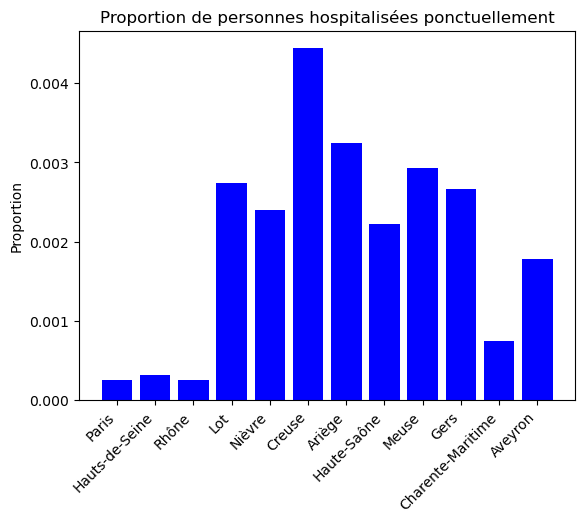

In [103]:
# Liste des départements
departements = ['Paris', 'Hauts-de-Seine', 'Rhône', 'Lot', 'Nièvre', 'Creuse', 'Ariège', 'Haute-Saône', 'Meuse', 'Gers', 'Charente-Maritime', 'Aveyron']

#Patho_niv1 sélectionné
x = 'Cancers'

# Création de dictionnaires pour la suite
hospitalized_data_by_dep = {}
data_by_dep = {}
population_by_dep = {}
proportion_hospitalized_by_dep = {}

# Boucle pour filtrer les données pour chaque département
for dep in departements:
    data_by_dep[dep] = pop_eff_pol[pop_eff_pol['nom_dep'] == dep]

# Boucle pour filtrer les données pour chaque département
for dep in departements:
    dep_data = pop_eff_pol[pop_eff_pol['nom_dep'] == dep]
    hospitalized_data = dep_data[dep_data['patho_niv1'] == x]
    hospitalized_data_by_dep[dep] = hospitalized_data

# Boucle pour obtenir le nombre d'habitants pour chaque département
for dep in departements:
    population_by_dep[dep] = pop.loc[pop['dep'] == dep, 'total_habitants'].iloc[0]

# Boucle pour calculer les proportions pour chaque département
for dep in departements:
    # Filtrer les données hospitalisées pour le département actuel
    hospitalized_data = data_by_dep[dep][data_by_dep[dep]['patho_niv1'] == x]
    # Calculer la proportion de personnes hospitalisées
    proportion_hospitalized = len(hospitalized_data) / population_by_dep[dep]
    
    # Stocker la proportion dans le dictionnaire
    proportion_hospitalized_by_dep[dep] = proportion_hospitalized
    
# Créer une liste pour stocker les tailles des barres
sizes = []

# Boucle pour récupérer les proportions spécifiques à chaque département
for dep in departements:
    sizes.append(proportion_hospitalized_by_dep[dep])

# Créer un diagramme en barres
fig, ax = plt.subplots()
ax.bar(departements, sizes, color=['blue'])
ax.set_ylabel('Proportion')
ax.set_title('Proportion de personnes hospitalisées ponctuellement')
ax.set_xticks(ax.get_xticks())
ax.set_xticklabels(departements, rotation=45, ha='right')

plt.show()

In [105]:
type(pop_eff_pol['niveau_prioritaire'])

pandas.core.series.Series

In [ ]:
pop_eff_pol['niveau_prioritaire'].unique()

In [115]:
pop_eff_pol['niveau_prioritaire'].replace('1,2,3', np.nan, inplace=True)

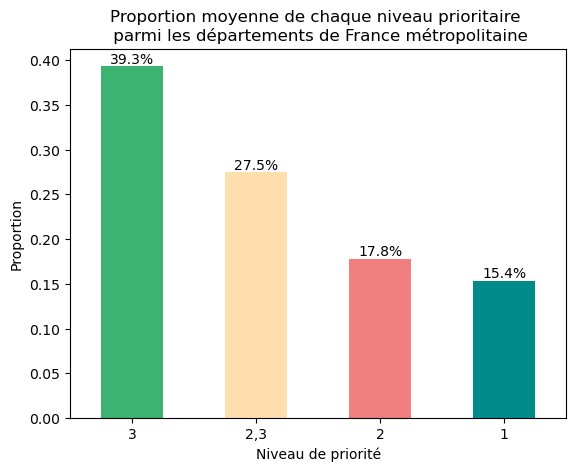

In [129]:
# Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
france_data = pop_eff_pol.sort_values(by='niveau_prioritaire')

# Calculer la proportion de chaque valeur de niveau_prioritaire
proportion_niveau_prioritaire = france_data['niveau_prioritaire'].value_counts(normalize=True)

# Créer un graphique à barres
ax = proportion_niveau_prioritaire.plot(kind='bar', color=['mediumseagreen', 'navajowhite', 'lightcoral', 'darkcyan'])
plt.ylabel('Proportion')
plt.xlabel('Niveau de priorité')
plt.title('Proportion moyenne de chaque niveau prioritaire \n parmi les départements de France métropolitaine')

# Appeler la fonction autolabel avec les barres actuelles
autolabel(ax.patches)

# Changer l'orientation des étiquettes de l'axe x
ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

plt.show()


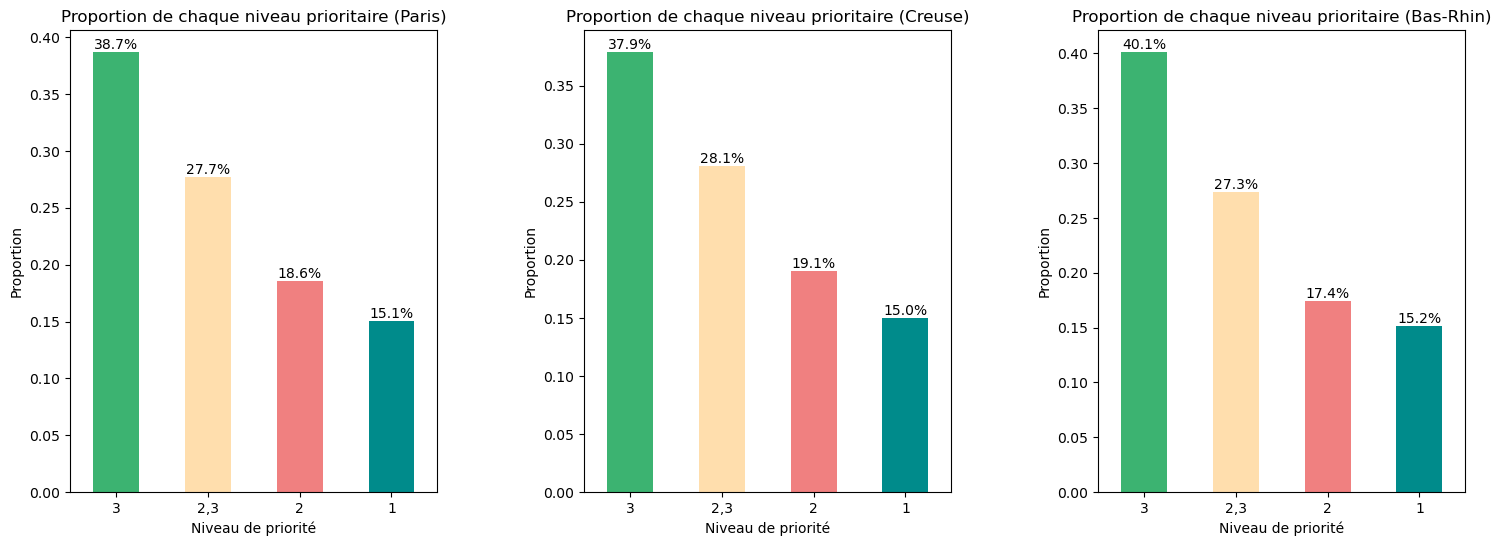

In [136]:
def plot_proportion_graph(ax, data, department):
    # Filtrer les données pour le département spécifié
    department_data = data[data['nom_dep'] == department]

    # Trier le DataFrame en fonction de la variable 'niveau_prioritaire'
    department_data = department_data.sort_values(by='niveau_prioritaire')

    # Calculer la proportion de chaque valeur de niveau_prioritaire
    proportion_niveau_prioritaire = department_data['niveau_prioritaire'].value_counts(normalize=True)

    # Créer un graphique à barres sur le sous-graphique spécifié
    proportion_niveau_prioritaire.plot(kind='bar', color=['mediumseagreen', 'navajowhite', 'lightcoral', 'darkcyan'], ax=ax)
    ax.set_ylabel('Proportion')
    ax.set_xlabel('Niveau de priorité')
    ax.set_title(f'Proportion de chaque niveau prioritaire ({department})')

    # Fonction pour ajouter les pourcentages au-dessus des barres
    def autolabel(rects):
        for rect in rects:
            height = rect.get_height()
            ax.text(rect.get_x() + rect.get_width() / 2., height, f'{height:.1%}',
                    ha='center', va='bottom')

    # Appeler la fonction autolabel
    autolabel(ax.patches)

    # Changer l'orientation des étiquettes de l'axe x
    ax.set_xticklabels(ax.get_xticklabels(), rotation=0)

# Créer une grille de 1 ligne par 3 colonnes pour les graphiques
fig, axes = plt.subplots(1, 3, figsize=(18, 6))

# Appeler la fonction pour chaque département avec son propre sous-graphique
plot_proportion_graph(axes[0], pop_eff_pol, 'Paris')
plot_proportion_graph(axes[1], pop_eff_pol, 'Creuse')
plot_proportion_graph(axes[2], pop_eff_pol, 'Bas-Rhin')

# Ajuster l'espacement entre les graphiques
plt.subplots_adjust(wspace=0.4)

# Afficher la grille de graphiques
plt.show()